# Grupo 3 - Modelos Machine Learning - Dataset: "**Campanhas de Marketing direto (chamadas telefónicas) de uma Instituição Bancária portuguesa**"

**Integrantes:**

- Gabriel dos Santos
- Gabriela Almeida
- Larissa Oliveira
- Livia Nobre
- Májda Alvarenga
- Nícolas Zocche


> Santander Coders 2024.1

> Turma #1175 - Data Science

> Professor Alex Lima - Machine Learning I

## Imports e leitura do dataset:

In [ ]:
!pip install lightgbm

In [ ]:
# Bibliotecas padrão
import os
import zipfile
import requests

# Bibliotecas para manipulação de dados
import numpy as np
import pandas as pd

# Bibliotecas para visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para modelagem e pré-processamento
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc

# Modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier

# Explicabilidade do modelo
import shap

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Sobre o Dataset


---



O dataset contém dados de campanhas de marketing direto de um banco em Portugal, realizadas por chamadas telefônicas para promover a subscrição de depósitos a prazo. Inclui quatro conjuntos de dados:


* **bank-additional-full.csv**: 41.188 exemplos, 20 atributos, ordenado por data
(maio/2008 a novembro/2010).
* **bank-additional.csv:** amostra de 10% do primeiro conjunto, com 4.119 exemplos e 20 atributos.
* **bank-full.csv:** 41.188 exemplos, 17 atributos, ordenado por data (versão antiga).
* **bank.csv:** amostra de 10% do terceiro conjunto, com 4.119 exemplos e 17 atributos.


---
Fonte:

• https://archive.ics.uci.edu/dataset/222/bank+marketing

---

#### Carregamento
Para essa construção, vamos utilizar o bank-additional, pois é a versão mais nova.

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"

# Acessar o arquivo .zip
zip_path = "bank-additional.zip"

response = requests.get(url)
with open(zip_path, "wb") as file:
    file.write(response.content)

print("Arquivo ZIP baixado com sucesso!")

# Extrair as pastas
extract_folder = "bank_data"

if not os.path.exists(extract_folder):
    os.makedirs(extract_folder)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)
extracted_files = os.listdir(extract_folder)
print("Arquivos extraídos:", extracted_files)

Arquivo ZIP baixado com sucesso!
Arquivos extraídos: ['bank-additional', '__MACOSX']


In [ ]:
# Acessar a pasta 'bank-additional'
bank_additional_folder = os.path.join(extract_folder, "bank-additional")

if os.path.exists(bank_additional_folder):
    additional_files = os.listdir(bank_additional_folder)
    print("Arquivos na pasta bank-additional:", additional_files)
else:
    print("Pasta 'bank-additional' não encontrada.")

Arquivos na pasta bank-additional: ['.Rhistory', 'bank-additional-full.csv', 'bank-additional.csv', 'bank-additional-names.txt', '.DS_Store']


In [ ]:
csv_path = os.path.join(bank_additional_folder, "bank-additional.csv")

bank = pd.read_csv(csv_path, sep=";")

df =pd.DataFrame(bank)

print(f'Há {df.shape[0]} linhas e {df.shape[1]} colunas.\n')
print('As primeiras linhas do dataset podem ser vistas abaixo: ')

df.head()

Há 4119 linhas e 21 colunas.

As primeiras linhas do dataset podem ser vistas abaixo: 


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


## **Bank Marketing**
---




### **O que é depósito a prazo?**

Um depósito a prazo, ou term deposit, é um tipo de investimento em que o cliente transfere uma quantia de dinheiro para uma conta específica, que fica "presa" por um período de tempo previamente definido, como 6 meses, 1 ano ou até mais.

Em troca, o banco oferece uma **taxa de juro fixa**, ou seja, uma taxa de retorno garantida que o cliente sabe desde o começo do investimento.

Os depósitos a prazo são semelhantes a contas poupança, mas existem diferenças importantes:

1. Nos depósitos a prazo, o cliente não pode acessar o dinheiro até ao fim do contrato.

2. Nos depósitos a prazo, a taxa de juro é fixa, enquanto nas contas poupança pode variar a qualquer momento.

Os depósitos a prazo são uma boa opção de investimento para quem procura um retorno estável e seguro. Podem ser úteis para poupar para itens maiores, como um carro, ou para investir quando o cliente quer ter certeza do interesse que vai ganhar.

O cliente e o banco acordam o período de tempo e a taxa de juro para uma conta de depósito a prazo. Os depósitos podem variar de valor e os termos podem durar de um mês a até 10 anos.

Se o cliente precisar de acessar ao dinheiro antes do esperado, provavelmente terá de pagar uma taxa e um ajuste de juros.


### **Problema de Negócio**

Os dados estão relacionados com campanhas de marketing direto (ligações telefônicas) de uma instituição bancária portuguesa.
O objetivo da classificação é responder a seguinte questão:

**"O cliente irá subscrever um depósito a prazo (variável y) após o contato da campanha de marketing direto?"**



### **Descrição das Variáveis**

Para isso, temos as seguintes variáveis no Dataset:

### Dados do Cliente Bancário

| **#** | **Nome da Variável (Português)**       | **Nome da Variável (Inglês)** | **Papel** | **Tipo**     | **Demográfico** | **Descrição** |
|-------|----------------------------------------|--------------------------------|-----------|--------------|-----------------|---------------|
| 1     | idade                                  | age                            | Feature   | Numérica     | Idade           | Idade do cliente. |
| 2     | ocupação                               | job                            | Feature   | Categórica   | Ocupação        | Tipo de trabalho do cliente: "admin.", "blue-collar", "entrepreneur", "housemaid", "management", "retired", "self-employed", "services", "student", "technician", "unemployed", "unknown". |
| 3     | estado civil                           | marital                        | Feature   | Categórica   | Estado Civil    | Estado civil do cliente: "divorced", "married", "single", "unknown"; note: "divorced" inclui viúvos. |
| 4     | educação                               | education                      | Feature   | Categórica   | Nível de Educação | Nível educacional do cliente: "basic.4y", "basic.6y", "basic.9y", "high.school", "illiterate", "professional.course", "university.degree", "unknown". |
| 5     | inadimplente                           | default                        | Feature   | Binária      |                 | O cliente está em inadimplência? |
| 6     | habitação                              | housing                        | Feature   | Binária      |                 | O cliente possui um empréstimo habitacional? |
| 7     | empréstimo pessoal                     | loan                           | Feature   | Binária      |                 | O cliente possui um empréstimo pessoal? |

### Relacionados com o Último Contato da Campanha Atual

| **#** | **Nome da Variável (Português)**       | **Nome da Variável (Inglês)** | **Papel** | **Tipo**     | **Descrição** |
|-------|----------------------------------------|--------------------------------|-----------|--------------|---------------|
| 8     | contato                                | contact                        | Feature   | Categórica   | Tipo de comunicação de contato: "cellular", "telephone". |
| 9     | dia_da_semana                          | day_of_week                    | Feature   | Categórica   | Dia da semana do último contato. |
| 10    | mês                                    | month                          | Feature   | Categórica   | Mês do último contato: "jan", "feb", "mar", ..., "nov", "dec". |
| 11    | duração                                | duration                       | Feature   | Numérica     | Duração do último contato, em segundos. |

*Nota: duração - este atributo afeta a variável alvo. Se a duração for 0, y = "não". Deve ser descartado em modelos preditivos realistas.*

### Outros Atributos

| **#** | **Nome da Variável (Português)**       | **Nome da Variável (Inglês)** | **Papel** | **Tipo**     | **Descrição** |
|-------|----------------------------------------|--------------------------------|-----------|--------------|---------------|
| 12    | campanha                               | campaign                       | Feature   | Numérica     | Número de contatos realizados durante a campanha, incluindo o último contato. |
| 13    | pdays                                  | pdays                          | Feature   | Numérica     | Dias desde o último contato em uma campanha anterior; -1 significa que o cliente não foi contatado anteriormente. |
| 14    | anterior                               | previous                       | Feature   | Numérica     | Número de contatos realizados antes desta campanha. |
| 15    | poutcome                               | poutcome                       | Feature   | Categórica   | Resultado da campanha de marketing anterior: "failure", "nonexistent", "success". |

### Atributos do Contexto Social e Econômico

| **#** | **Nome da Variável (Português)**       | **Nome da Variável (Inglês)** | **Papel** | **Tipo**     | **Descrição** |
|-------|----------------------------------------|--------------------------------|-----------|--------------|---------------|
| 16    | taxa de variação do emprego            | emp.var.rate                   | Feature   | Numérica     | Indicador trimestral da taxa de variação do emprego. |
| 17    | índice de preços ao consumidor         | cons.price.idx                 | Feature   | Numérica     | Índice de preços ao consumidor (mensal). |
| 18    | índice de confiança do consumidor      | cons.conf.idx                  | Feature   | Numérica     | Índice de confiança do consumidor (mensal). |
| 19    | euribor3m                              | euribor3m                      | Feature   | Numérica     | Taxa euribor de 3 meses (diária). |
| 20    | número de empregados                   | nr.employed                    | Feature   | Numérica     | Indicador trimestral do número de empregados. |

### Variável de Saída (Alvo)

| **#** | **Nome da Variável (Português)**       | **Nome da Variável (Inglês)** | **Papel** | **Tipo**     | **Descrição** |
|-------|----------------------------------------|--------------------------------|-----------|--------------|---------------|
| 21    | subscrição de depósito a prazo         | y                              | Target    | Binária      | O cliente subscreveu um depósito a prazo? "sim", "não". |

### Valores Ausentes nos Atributos
Existem vários valores ausentes em alguns atributos categóricos, todos codificados com o rótulo "desconhecido". Esses valores ausentes podem ser tratados como uma possível classe ou usando técnicas de exclusão ou imputação.


## **Análise exploratória**

### Análise Geral

In [ ]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [ ]:
#tipos das colunas de df
df.dtypes

,0
age,int64
job,object
marital,object
education,object
default,object
housing,object
loan,object
contact,object
month,object
day_of_week,object


In [ ]:
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


Não vamos utilizar a coluna ***'day_of_week'*** por isso tiramos do DataFrame.

In [ ]:
df = df.drop('day_of_week', axis=1)

### Divisão das Variáveis em Númericas e Categóricas

In [ ]:
numerical_cols = df.select_dtypes(include=['number']).columns

print("Colunas Numéricas:")
for col in numerical_cols:
    print(f"- {col}")

Colunas Numéricas:
- age
- duration
- campaign
- pdays
- previous
- emp.var.rate
- cons.price.idx
- cons.conf.idx
- euribor3m
- nr.employed


In [ ]:
non_numerical_cols = df.select_dtypes(exclude=['number']).columns.drop('y')

print("Colunas Categóricas:")
for col in non_numerical_cols:
    print(f"- {col}")

Colunas Categóricas:
- job
- marital
- education
- default
- housing
- loan
- contact
- month
- poutcome


In [ ]:
# valores para cada coluna

for col in df[non_numerical_cols]:
  print(f"**Valores para a coluna '{col}':**")
  print(df[col].value_counts())
  print("\n" + "="*50 + "\n")

**Valores para a coluna 'job':**
job
admin.           1012
blue-collar       884
technician        691
services          393
management        324
retired           166
self-employed     159
entrepreneur      148
unemployed        111
housemaid         110
student            82
unknown            39
Name: count, dtype: int64


**Valores para a coluna 'marital':**
marital
married     2509
single      1153
divorced     446
unknown       11
Name: count, dtype: int64


**Valores para a coluna 'education':**
education
university.degree      1264
high.school             921
basic.9y                574
professional.course     535
basic.4y                429
basic.6y                228
unknown                 167
illiterate                1
Name: count, dtype: int64


**Valores para a coluna 'default':**
default
no         3315
unknown     803
yes           1
Name: count, dtype: int64


**Valores para a coluna 'housing':**
housing
yes        2175
no         1839
unknown     105
Name: count, dt

In [ ]:
df_numerico=df[numerical_cols]
df_numerico.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,30,487,2,999,0,-1.8,92.893,-46.2,1.313,5099.1
1,39,346,4,999,0,1.1,93.994,-36.4,4.855,5191.0
2,25,227,1,999,0,1.4,94.465,-41.8,4.962,5228.1
3,38,17,3,999,0,1.4,94.465,-41.8,4.959,5228.1
4,47,58,1,999,0,-0.1,93.200,-42.0,4.191,5195.8


In [ ]:
df_numerico.describe().round()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,4119.0,4119.0,4119.0,4119.0,4119.0,4119.0,4119.0,4119.0,4119.0,4119.0
mean,40.0,257.0,3.0,960.0,0.0,0.0,94.0,-40.0,4.0,5166.0
std,10.0,255.0,3.0,192.0,1.0,2.0,1.0,5.0,2.0,74.0
min,18.0,0.0,1.0,0.0,0.0,-3.0,92.0,-51.0,1.0,4964.0
25%,32.0,103.0,1.0,999.0,0.0,-2.0,93.0,-43.0,1.0,5099.0
50%,38.0,181.0,2.0,999.0,0.0,1.0,94.0,-42.0,5.0,5191.0
75%,47.0,317.0,3.0,999.0,0.0,1.0,94.0,-36.0,5.0,5228.0
max,88.0,3643.0,35.0,999.0,6.0,1.0,95.0,-27.0,5.0,5228.0


### Correlação das Variáveis Numéricas

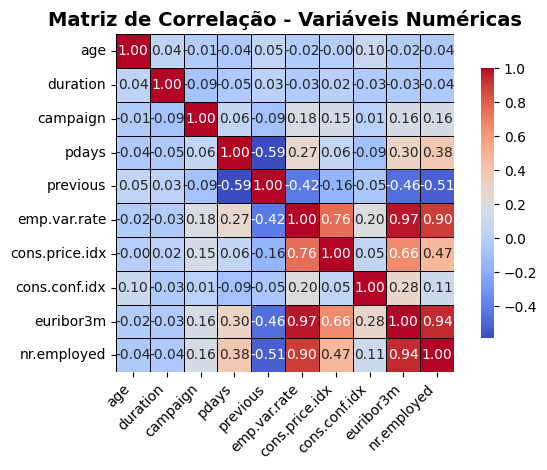

In [ ]:
correlation_matrix = df_numerico.corr()

heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
                      square=True, cbar_kws={"shrink": .8}, linewidths=.5, linecolor='black')


plt.title('Matriz de Correlação - Variáveis Numéricas', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## **Analisando a Proposição Inicial**

#### **1. Analisando as campanhas**

In [ ]:
antes_campanhas = df.groupby('previous')['y'].value_counts().unstack().fillna(0)

antes_campanhas.columns = ['Não Subscrição', 'Subscrição']

# Renomear o índice para algo mais descritivo em português
antes_campanhas.index.name = 'Número de Contatos Antes da Campanha'

# Exibir o resultado
print(antes_campanhas)

                                      Não Subscrição  Subscrição
Número de Contatos Antes da Campanha                            
0                                             3231.0       292.0
1                                              376.0        99.0
2                                               46.0        32.0
3                                               10.0        15.0
4                                                4.0        10.0
5                                                0.0         2.0
6                                                1.0         1.0


In [ ]:
campanhas = df.groupby('campaign')['y'].value_counts().unstack().fillna(0)

campanhas.columns = ['Não Subscrição', 'Subscrição']

campanhas.index.name = 'Número de Contatos Durante a Campanha'

# Exibir o resultado
print(campanhas)


                                       Não Subscrição  Subscrição
Número de Contatos Durante a Campanha                            
1                                              1545.0       219.0
2                                               920.0       119.0
3                                               487.0        62.0
4                                               259.0        32.0
5                                               133.0         9.0
6                                                95.0         4.0
7                                                59.0         1.0
8                                                34.0         2.0
9                                                31.0         1.0
10                                               19.0         1.0
11                                               18.0         1.0
12                                               16.0         0.0
13                                               11.0         0.0
14        

df.groupby('campaign')['y'].value_counts().unstack()

#### **Conclusão:**
A maior parte dos clientes não foi contactada previamente. Não é possível validar o modelo de marketing através da quantidade de contatos. O ideal seria investir nas classes de maior probabilidade de depósito.

#### **2. Análises das categorias**

In [ ]:
df['y'].value_counts()

,count
y,
no,3668
yes,451


In [ ]:
df_sim = df[df['y'] == 'yes']
df_nao = df[df['y'] == 'no']

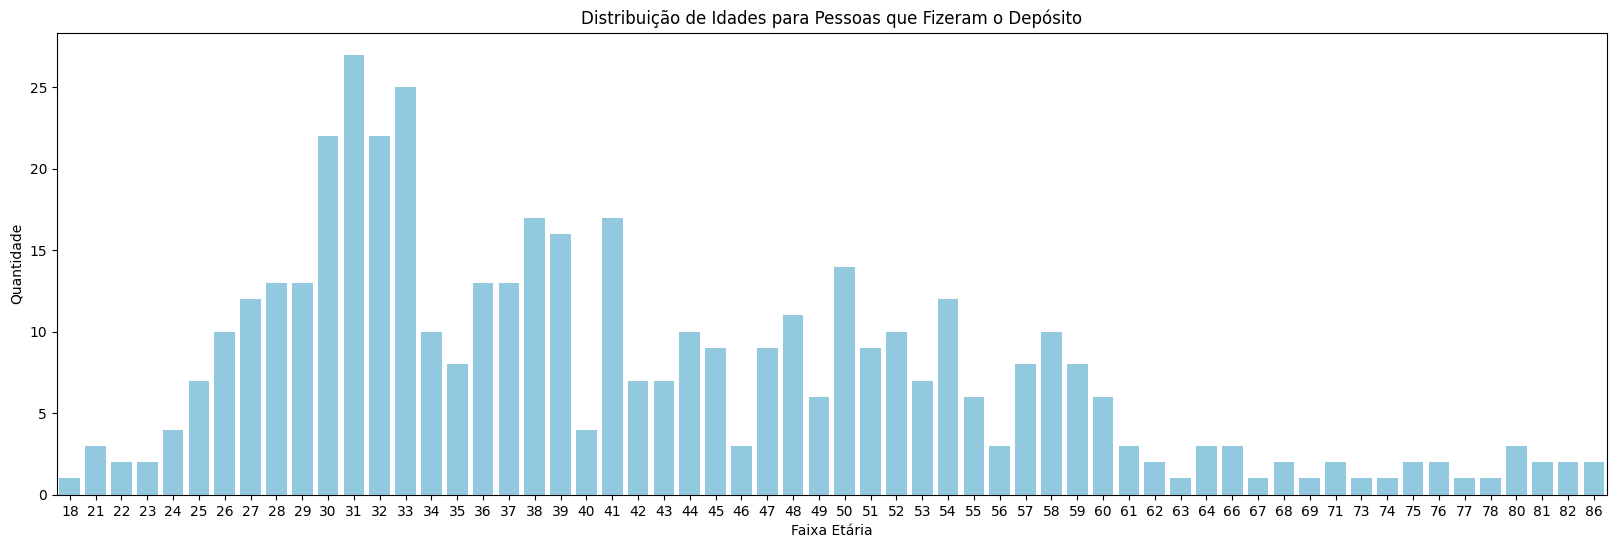

In [ ]:
plt.figure(figsize=(20, 6))
sns.countplot(data=df_sim, x='age', color='skyblue')
plt.title("Distribuição de Idades para Pessoas que Fizeram o Depósito")
plt.xlabel("Faixa Etária")
plt.ylabel("Quantidade")
plt.show()

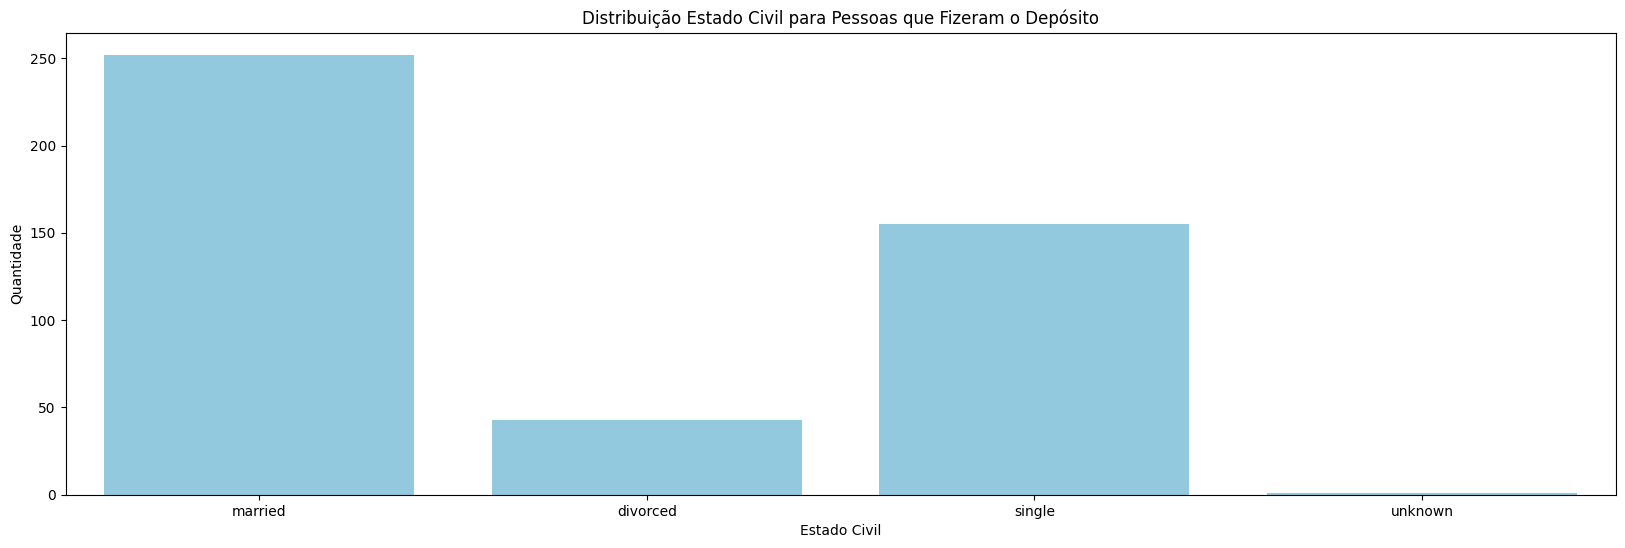

In [ ]:
plt.figure(figsize=(20, 6))
sns.countplot(data=df_sim, x='marital', color='skyblue')
plt.title("Distribuição Estado Civil para Pessoas que Fizeram o Depósito")
plt.xlabel("Estado Civil")
plt.ylabel("Quantidade")
plt.show()

In [ ]:
df['contact'].value_counts()

,count
contact,
cellular,2652
telephone,1467


In [ ]:
df_celular = df[df['contact'] == 'celular']
df_telefone = df[df['contact'] == 'telephone']

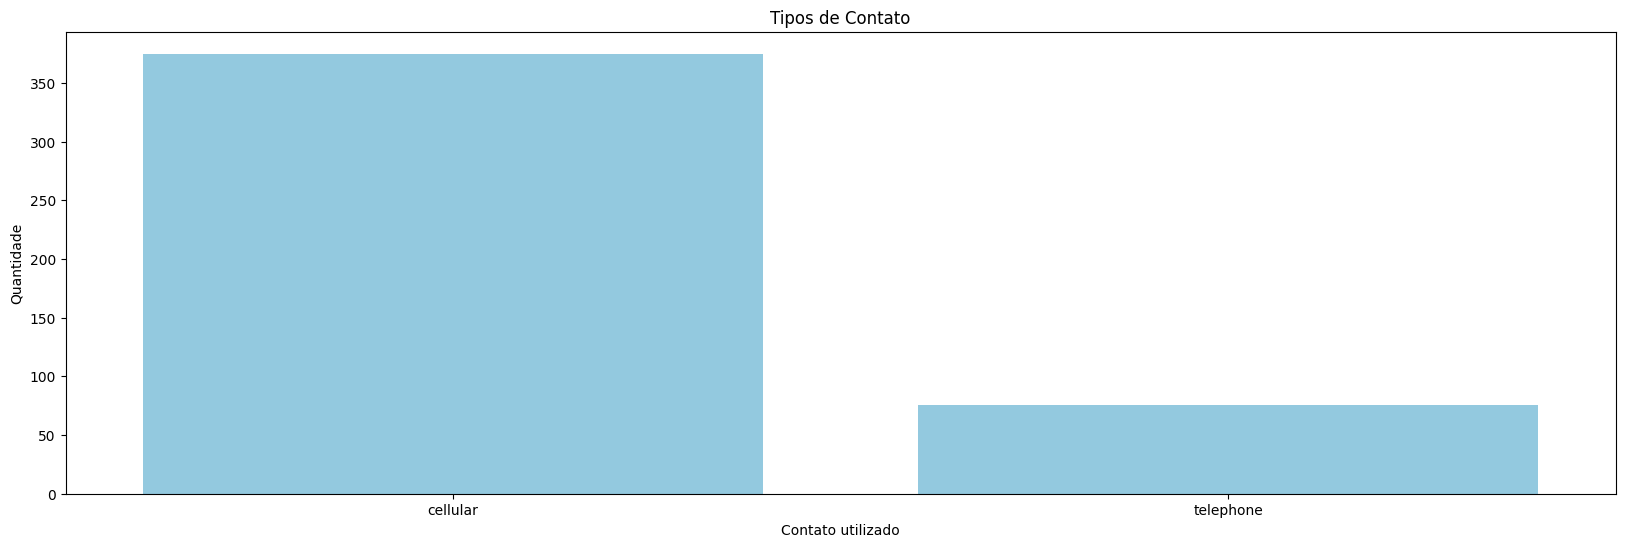

In [ ]:
plt.figure(figsize=(20, 6))
sns.countplot(data=df_sim, x='contact', color='skyblue')
plt.title("Tipos de Contato")
plt.xlabel("Contato utilizado")
plt.ylabel("Quantidade")
plt.show()

In [ ]:
df.groupby('age')['default'].value_counts().sort_values(ascending=False)

,,count
age,default,
32,no,198
31,no,174
30,no,156
34,no,153
33,no,145
...,...,...
19,unknown,1
76,unknown,1
63,unknown,1


#### **Conclusão:**
O foco da campanha seria contactar pessoas na faixa dos 28 a 38 anos, casadas, sem inadimplência e o contato deverá ser realizado pelo celular!

## **Pré-processamento**

In [ ]:
non_numerical_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')

In [ ]:
# Converter variáveis categóricas para numéricas usando One-Hot Encoding
df = pd.get_dummies(df, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome'],  dtype=int)

# Transformar a variável de destino (y) em valores numéricos (0 ou 1)
df['y'] = df['y'].map({'no': 0, 'yes': 1})

df.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_nonexistent,poutcome_success
0,30,487,2,999,0,-1.8,92.893,-46.2,1.313,5099.1,...,0,0,0,1,0,0,0,0,1,0
1,39,346,4,999,0,1.1,93.994,-36.4,4.855,5191.0,...,0,0,0,1,0,0,0,0,1,0
2,25,227,1,999,0,1.4,94.465,-41.8,4.962,5228.1,...,0,1,0,0,0,0,0,0,1,0
3,38,17,3,999,0,1.4,94.465,-41.8,4.959,5228.1,...,0,1,0,0,0,0,0,0,1,0
4,47,58,1,999,0,-0.1,93.200,-42.0,4.191,5195.8,...,0,0,0,0,1,0,0,0,1,0


## **Divisão de Treino e Teste**

In [ ]:
# Separando dataset de target e dropando colunas não numéricas
X = df.drop(['y'], axis=1)
y = df['y']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)

## **Treinamento de modelos**

### **1. Decision Tree**

Accuracy: 0.8770
Precision: 0.4331
Recall: 0.5191
F1-score: 0.4722
ROC AUC: 0.7193


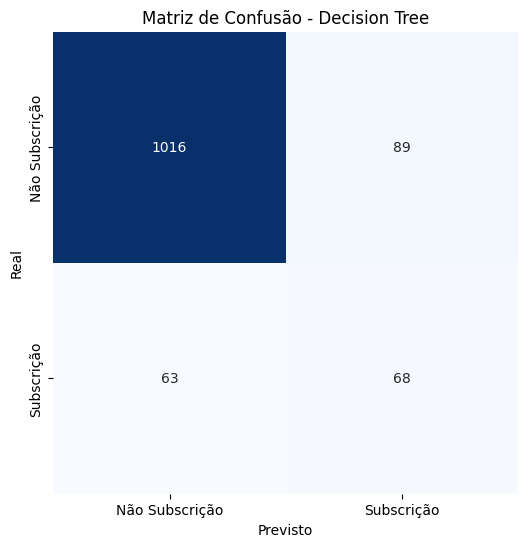

In [ ]:
# Construção do modelo
DT_model = DecisionTreeClassifier(random_state=42)

# Treinamento do modelo
DT_model.fit(X_train, y_train)

# Predição do modelo
y_pred = DT_model.predict(X_test)

# Métricas do modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)  # Mais importante para fraude bancária
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Não Subscrição', 'Subscrição'], yticklabels=['Não Subscrição', 'Subscrição'])
plt.title("Matriz de Confusão - Decision Tree")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()


O modelo alcançou uma boa **Accuracy (87,7%)** devido ao desequilíbrio da base (mais negativos que positivos), mas as métricas de **Precision** e **Recall** são baixas, indicando que ele pode melhorar na detecção de casos positivos. O **ROC AUC de 0,719** mostra uma capacidade moderada de distinguir entre as classes, com margem para aprimoramento.

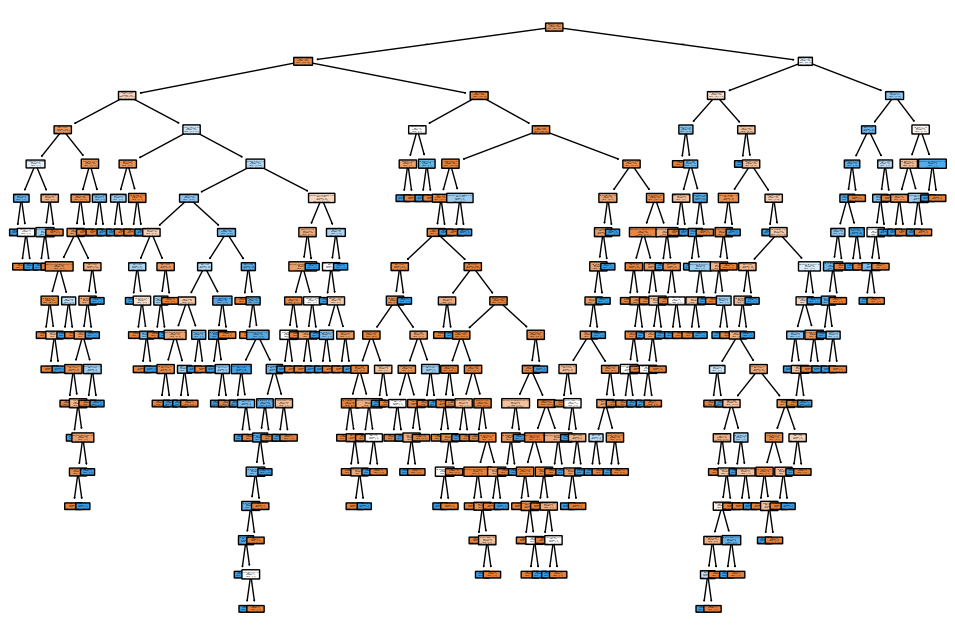

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(12, 8))
plot_tree(DT_model, filled=True, feature_names=X_train.columns, class_names=['Não Subscrição', 'Subscrição'], rounded=True)
plt.show()

#### ***Otimização do hiperparâmetro***

In [ ]:
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

DT_best_model = grid_search.best_estimator_
y_pred = DT_best_model.predict(X_test)

print(f"Best parameters: {grid_search.best_params_}")


Best parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [ ]:
# Previsões com o modelo otimizado
y_pred = DT_best_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)


print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")



Accuracy: 0.9013
Precision: 0.5378
Recall: 0.4885
F1-score: 0.5120
ROC AUC: 0.7194


Após o ajuste dos hiperparâmetros, o modelo apresentou uma **Accuracy ligeiramente melhor (90,1%)** e um **aumento na Precision (53,8%)**, sugerindo uma maior precisão ao identificar casos positivos. O **Recall e o F1-score tiveram uma pequena variação**, indicando que a otimização teve um impacto limitado na sensibilidade. O **ROC AUC permaneceu quase inalterado (71,9%)**, sinalizando uma discriminação moderada entre as classes e ainda sugerindo que há espaço para mais melhorias.

### **2. Random Forest**

Nesse modelo, adicionamos o parâmetro de ***_class_weight = 'balanced*** para vermos o comportamento.

Accuracy: 0.9029
Precision: 0.5902
Recall: 0.2748
F1-score: 0.3750
ROC AUC: 0.6261


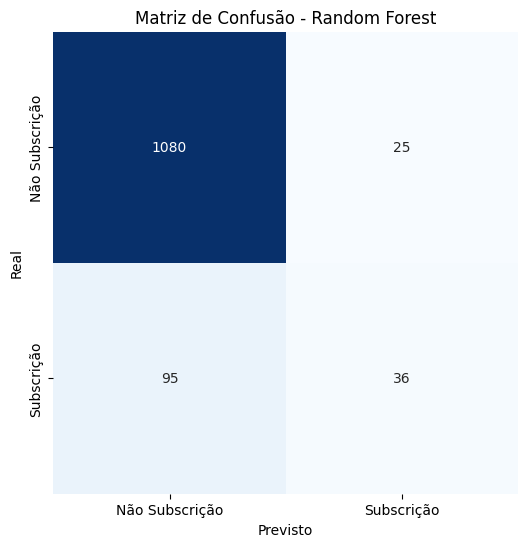

In [ ]:
# Construção do modelo
RF_model = RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced')

# Treinamento do modelo
RF_model.fit(X_train, y_train)

# Predição do modelo
y_pred = RF_model.predict(X_test)

# Métricas do modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Não Subscrição', 'Subscrição'], yticklabels=['Não Subscrição', 'Subscrição'])
plt.title("Matriz de Confusão - Random Forest")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()


Os resultados mostram que o modelo **Random Forest** alcançou uma **boa Accuracy de 90,29%**, porém as métricas de **Precision e Recall** continuam relativamente **baixas**, com o **Recall** sendo **inferior** ao do **modelo otimizado de Decision Tree**. Embora a Precision do Random Forest seja razoável, o modelo está deixando de identificar uma quantidade significativa de casos positivos. Isso sugere que o Random Forest não está tão eficaz na detecção em comparação ao modelo de Decision Tree otimizado.

### **3. AdaBooster**

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.9078
Precision: 0.6349
Recall: 0.3053
F1-score: 0.4124
ROC AUC: 0.6423


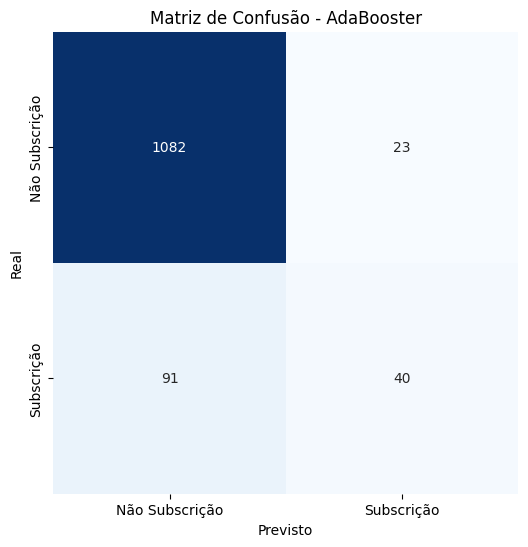

In [ ]:
# Construção do modelo
ADA_model = AdaBoostClassifier(
                                n_estimators=100,
                                learning_rate=0.1,
                                algorithm='SAMME.R',
                                random_state=42
)

# Treinamento do modelo
ADA_model.fit(X_train, y_train)

# Predição do modelo
y_pred = ADA_model.predict(X_test)

# Métricas do modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Não Subscrição', 'Subscrição'], yticklabels=['Não Subscrição', 'Subscrição'])
plt.title("Matriz de Confusão - AdaBooster")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()


Neste modelo, a **Precision** foi **maior**, alcançando **63,49%**, mas ainda assim o modelo não consegue identificar muitos dos casos positivos, como mostrado pelo **F1-score** de **41,24%**. A **ROC AUC** de **64,23%** indica uma capacidade moderada de discriminação entre as classes. Isso sugere que, embora o modelo tenha uma boa Accuracy, ele pode ser melhorado para aprimorar a detecção de casos positivos.

### **4. XGBooster**

Accuracy: 0.9005
Precision: 0.5312
Recall: 0.5191
F1-score: 0.5251
ROC AUC: 0.7324


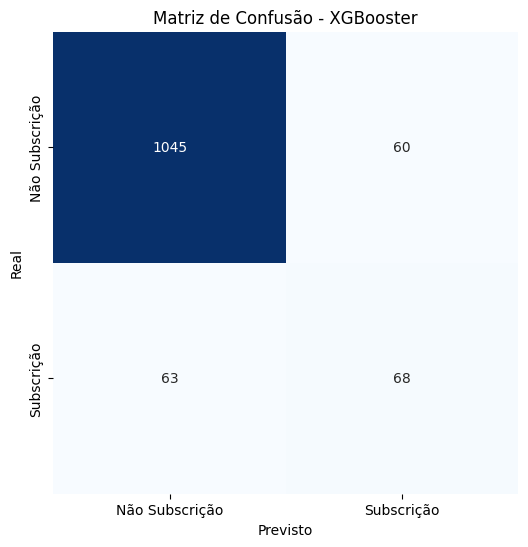

In [ ]:
# Construção do modelo
XGB_model = xgb.XGBClassifier()

# Treinamento do modelo
XGB_model.fit(X_train, y_train)

# Predição do modelo
y_pred = XGB_model.predict(X_test)

# Métricas do modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Não Subscrição', 'Subscrição'], yticklabels=['Não Subscrição', 'Subscrição'])
plt.title("Matriz de Confusão - XGBooster")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()


No modelo XGBoost, os resultados de **Recall (51,91%)** e **F1-score (52,51%)** são melhores em comparação com outros modelos, como o Random Forest e o AdaBoost. Isso indica que o modelo XGBoost conseguiu identificar melhor os casos positivos, o que é importante em problemas de classificação desbalanceada.

Embora os resultados de **Precision (53,12%)** e **ROC AUC (73,24%)** não sejam tão altos quanto desejado, o modelo já demonstra um desempenho relativamente bom.

#### ***Otimização do hiperparâmetro***

In [ ]:
param_dist_xgb = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 10],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'scale_pos_weight': [1, 5, 10, 15]
}


XGB_model_best = xgb.XGBClassifier(random_state=42)


random_search_xgb = RandomizedSearchCV(estimator=XGB_model_best, param_distributions=param_dist_xgb,
                                       n_iter=10, cv=5, n_jobs=-1, random_state=42, scoring='accuracy')


random_search_xgb.fit(X_train, y_train)


best_model_xgb_random = random_search_xgb.best_estimator_


y_pred_optimized_random = best_model_xgb_random.predict(X_test)


accuracy = accuracy_score(y_test, y_pred_optimized_random)
precision = precision_score(y_test, y_pred_optimized_random)
recall = recall_score(y_test, y_pred_optimized_random)
f1 = f1_score(y_test, y_pred_optimized_random)
roc_auc = roc_auc_score(y_test, y_pred_optimized_random)


print(f"Best Parameters (RandomizedSearchCV): {random_search_xgb.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Best Parameters (RandomizedSearchCV): {'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 50, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Accuracy: 0.9005
Precision: 0.5417
Recall: 0.3969
F1-score: 0.4581
ROC AUC: 0.6786


A otimização dos hiperparâmetros **não** melhorou o desempenho geral do modelo em termos de Recall e F1-score, e até resultou em uma redução na capacidade de identificar casos positivos.

O modelo parece ter priorizado precisão em detrimento de recall.

### **5. LightGBM**

Neste modelo, ajustamos a **função de custo** para penalizar mais os erros na classe positiva. Esse ajuste foi realizado por meio da modificação do parâmetro **scale_pos_weight**, o qual aumenta o peso da classe positiva durante o treinamento, ajudando o modelo a se concentrar mais na identificação correta das instâncias dessa classe, especialmente nesse caso de desbalanceamento.

[LightGBM] [Info] Number of positive: 320, number of negative: 2563
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 2883, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110995 -> initscore=-2.080613
[LightGBM] [Info] Start training from score -2.080613
Accuracy: 0.8843
Precision: 0.4684
Recall: 0.6794
F1-score: 0.5545
ROC AUC: 0.7940


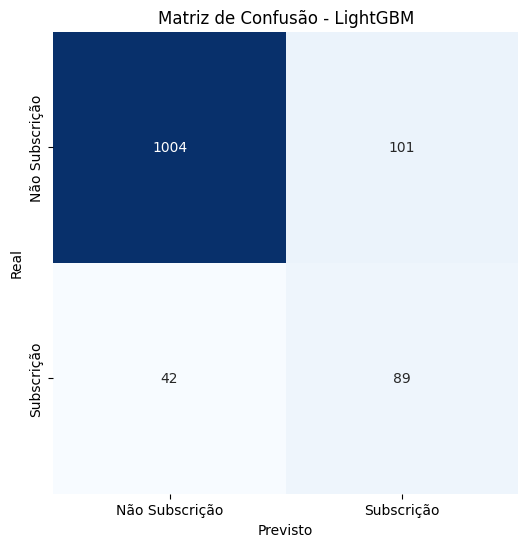

In [ ]:
num_negativos = len(y_train) - sum(y_train)  # Total de instâncias negativas
num_positivos = sum(y_train)                # Total de instâncias positivas

scale_pos_weight = num_negativos / num_positivos  # Razão de classe

# Construção do modelo
LGBM_model = lgb.LGBMClassifier(scale_pos_weight=scale_pos_weight, random_state=42)

# Treinamento do modelo
LGBM_model.fit(X_train, y_train)

# Predição do modelo
y_pred = LGBM_model.predict(X_test)

# Métricas do modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Não Subscrição', 'Subscrição'], yticklabels=['Não Subscrição', 'Subscrição'])
plt.title("Matriz de Confusão - LightGBM")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()



O ajuste de scale_pos_weight melhorou significativamente o desempenho do modelo para lidar com o desbalanceamento de classes. Embora o **accuracy** tenha **caído** ligeiramente em comparação ao valor sem o ajuste, o modelo agora tem um **recall muito melhor** (capturando mais instâncias da classe minoritária) e um **F1-score mais alto**, o que sugere que a qualidade da classificação foi aprimorada, especialmente em relação à classe minoritária. A **melhoria na ROC AUC** também confirma que a capacidade de discriminação do modelo foi aprimorada.

### **6. KNN**

Accuracy: 0.8948
Precision: 0.5044
Recall: 0.4351
F1-score: 0.4672
ROC AUC: 0.6922
Cross-validated accuracy: 0.9025


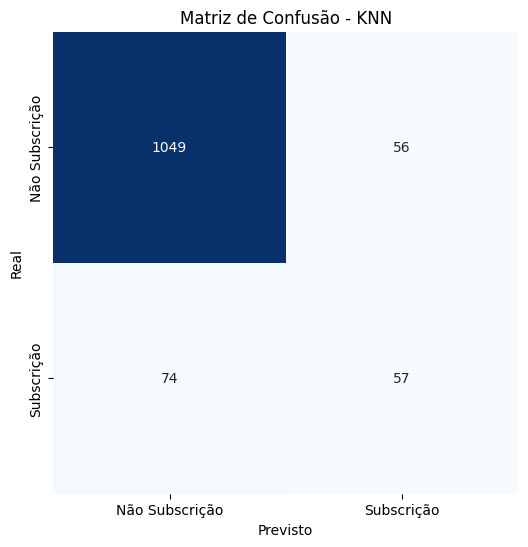

In [ ]:
# Construção do modelo
knn_model = KNeighborsClassifier(n_neighbors=3)

# Treinamento do modelo
knn_model.fit(X_train, y_train)

# Predição do modelo
y_pred = knn_model.predict(X_test)

# Métricas do modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

from sklearn.model_selection import cross_val_score
scores = cross_val_score(knn_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validated accuracy: {scores.mean():.4f}")

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Não Subscrição', 'Subscrição'], yticklabels=['Não Subscrição', 'Subscrição'])
plt.title("Matriz de Confusão - KNN")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()


#### ***Otimização do hiperparâmetro***

In [ ]:
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}


grid_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')


grid_search.fit(X_train, y_train)


print("Melhores hiperparâmetros encontrados:")
print(grid_search.best_params_)


best_knn_model = KNeighborsClassifier(**grid_search.best_params_)

best_knn_model.fit(X_train, y_train)


y_pred = best_knn_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


Melhores hiperparâmetros encontrados:
{'metric': 'euclidean', 'n_neighbors': 17, 'weights': 'uniform'}
Accuracy: 0.9045
Precision: 0.5607
Recall: 0.4580
F1-score: 0.5042
ROC AUC: 0.7077


## **Comparação de modelos**

           Model  Accuracy  Precision    Recall  F1-Score   ROC AUC
0  Decision Tree  0.877023   0.433121  0.519084  0.472222  0.719270
1  Random Forest  0.902913   0.590164  0.274809  0.375000  0.626092
2       AdaBoost  0.907767   0.634921  0.305344  0.412371  0.642265
3        XGBoost  0.900485   0.531250  0.519084  0.525097  0.732393
4       LightGBM  0.884304   0.468421  0.679389  0.554517  0.793993
5            KNN  0.894822   0.504425  0.435115  0.467213  0.692218


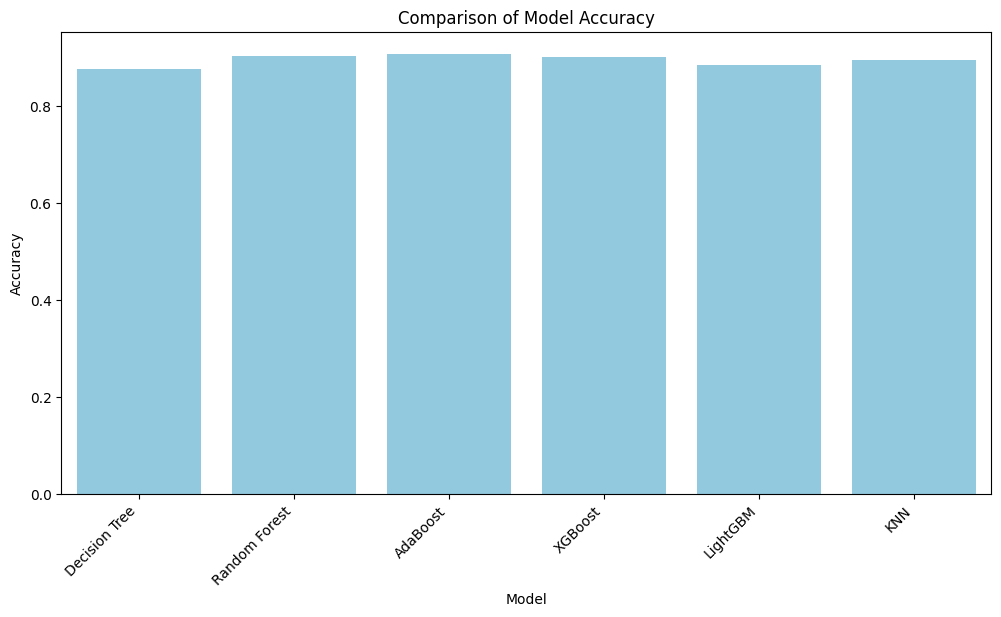

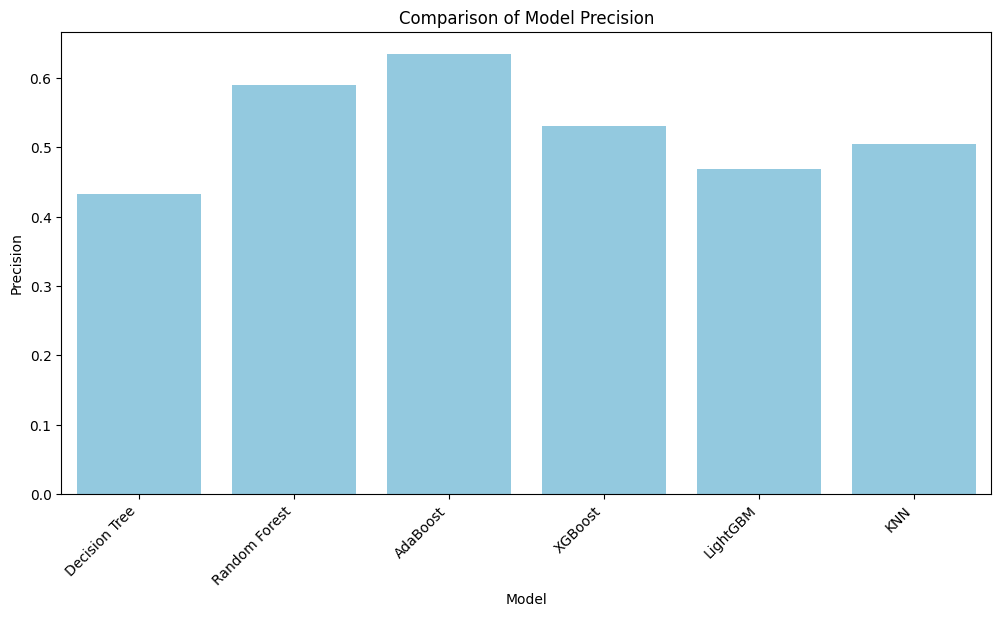

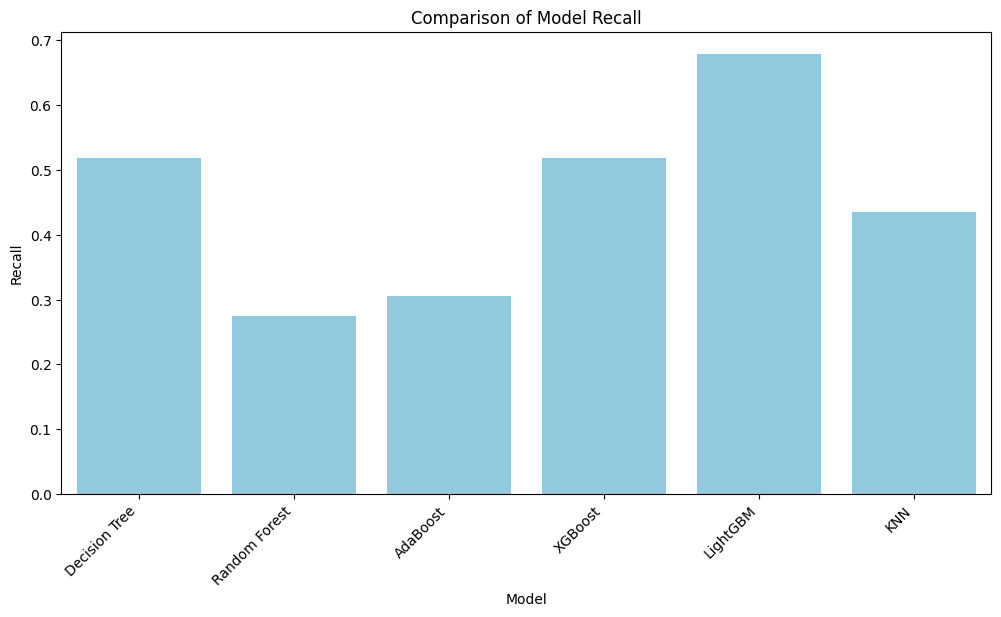

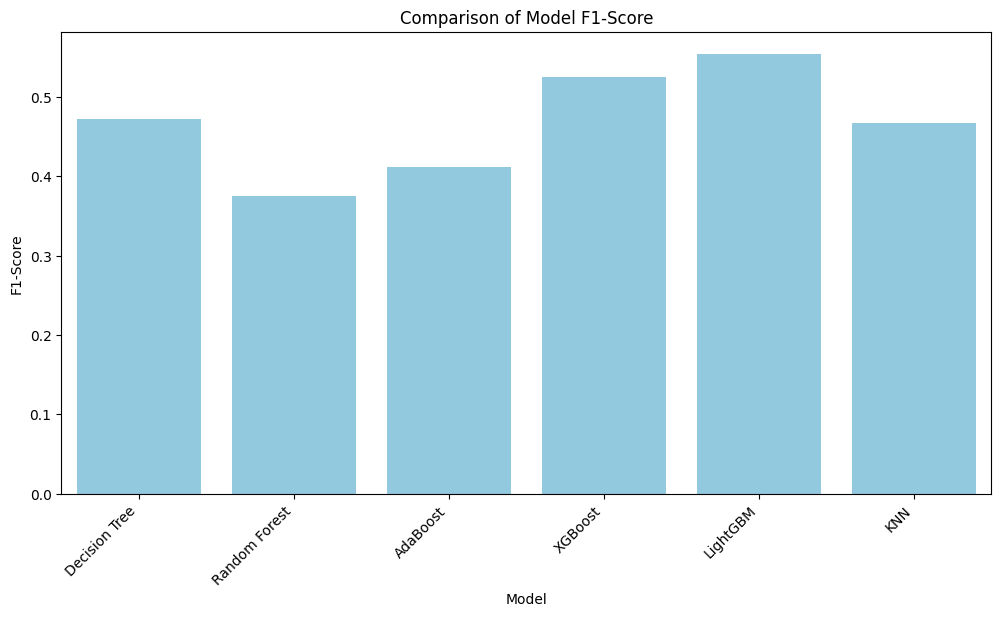

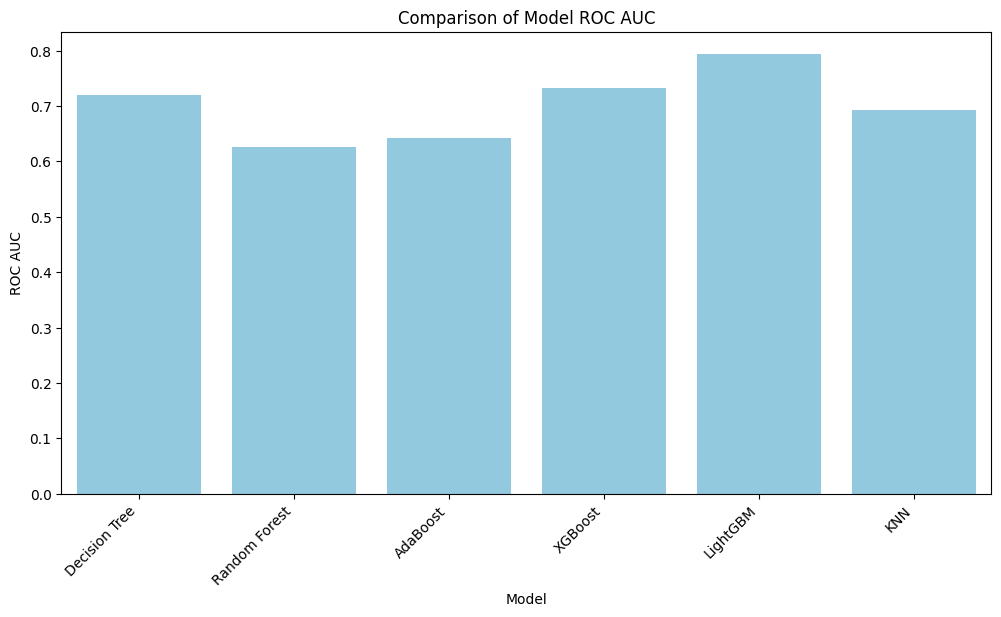

In [ ]:
models = {
    "Decision Tree": DT_model,
    "Random Forest": RF_model,
    "AdaBoost": ADA_model,
    "XGBoost": XGB_model,
    "LightGBM": LGBM_model,
    "KNN": knn_model
}

results = []
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    results.append([model_name, accuracy, precision, recall, f1, roc_auc])

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC AUC"])

print(results_df)


plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Accuracy", data=results_df, color='skyblue')
plt.title("Comparison of Model Accuracy")
plt.xticks(rotation=45, ha="right")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Precision", data=results_df, color='skyblue')
plt.title("Comparison of Model Precision")
plt.xticks(rotation=45, ha="right")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Recall", data=results_df, color='skyblue')
plt.title("Comparison of Model Recall")
plt.xticks(rotation=45, ha="right")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="F1-Score", data=results_df, color='skyblue')
plt.title("Comparison of Model F1-Score")
plt.xticks(rotation=45, ha="right")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="ROC AUC", data=results_df, color='skyblue')
plt.title("Comparison of Model ROC AUC")
plt.xticks(rotation=45, ha="right")
plt.show()

### Curva ROC dos Modelos

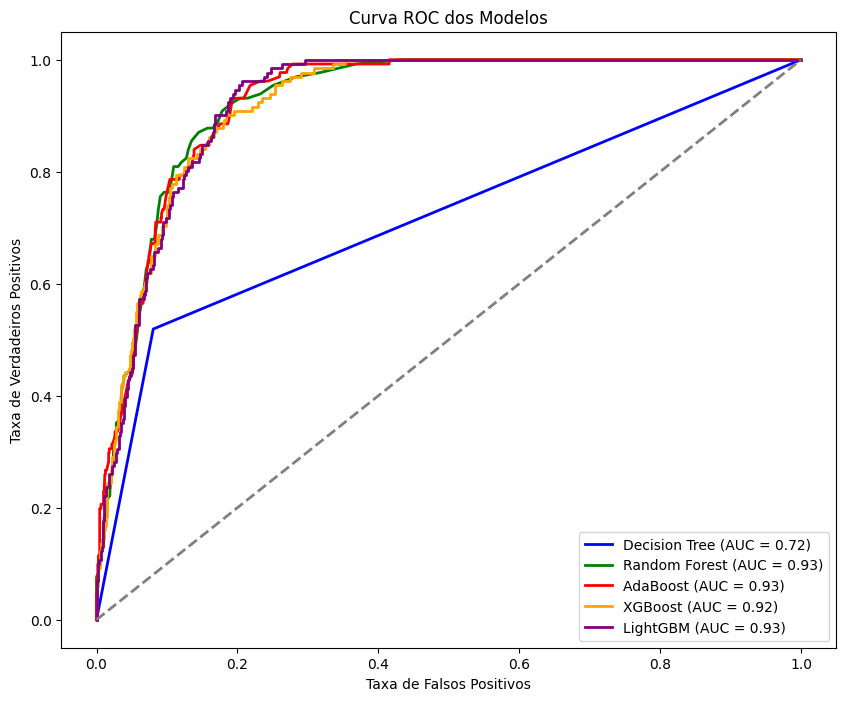

In [ ]:
models = [DT_model, RF_model, ADA_model, XGB_model, LGBM_model]
model_names = ['Decision Tree', 'Random Forest', 'AdaBoost', 'XGBoost', 'LightGBM']
colors = ['blue', 'green', 'red', 'orange', 'purple']

plt.figure(figsize=(10, 8))

for i, model in enumerate(models):
  y_pred_proba = model.predict_proba(X_test)[:, 1]
  fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{model_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC dos Modelos')
plt.legend(loc='lower right')
plt.show()

## **Conclusão**


O objetivo do dataset é avaliar quem assinou um termo de depósito (um problema de classificação binária). É importante escolher uma métrica que lide bem com possíveis desbalanceamentos nos dados, pois campanhas de marketing geralmente tem uma resposta positiva menor do que a negativa.

**Métrica recomendada:**

A métrica F1-Score é frequentemente útil, pois oferece um equilíbrio entre Precision (quantos dos resultados positivos previstos realmente são) e Recall (quantos dos positivos reais foram previstos corretamente).

Essa métrica é adequada para cenários onde é crítico tanto identificar corretamente os clientes que responderiam à campanha (minimizando falsos positivos) quanto não perder possíveis interessados (minimizando falsos negativos).

**Alternativa: ROC AUC**

Se você quiser uma visão global do desempenho do modelo em diferentes limiares de classificação (thresholds), o ROC AUC é uma boa opção, pois mede a capacidade do modelo de distinguir entre as duas classes em uma ampla gama de limiares. Ele é especialmente útil quando o conjunto de dados está desbalanceado, permitindo avaliar a habilidade do modelo em separar as classes de forma geral, sem se concentrar em um limiar específico.

**Em resumo:**

**F1-Score:** Caso seu foco seja equilibrar Precision e Recall.

No nosso caso, escolhendo pela métrica F1-Score, o modelo mais assertivo é o LightGBM

### Top 10 features pelo Modelo Escolhido

Top 10 Features:
                        Feature  Importance
1                      duration         673
0                           age         496
8                     euribor3m         375
6                cons.price.idx         152
2                      campaign         151
7                 cons.conf.idx         149
3                         pdays          72
9                   nr.employed          69
5                  emp.var.rate          62
32  education_university.degree          55


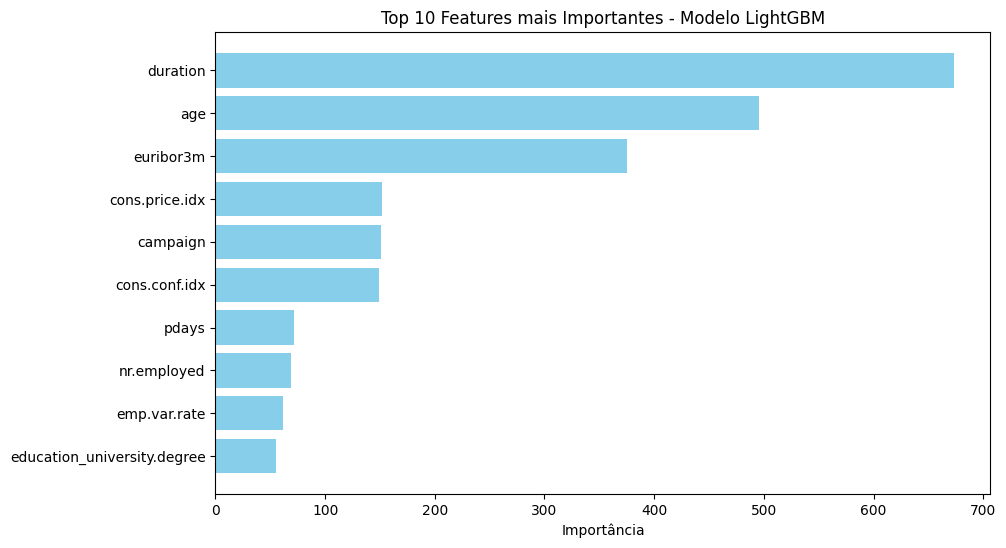

In [ ]:
feature_importances = LGBM_model.feature_importances_

features = X_test.columns

feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Top 10 Features:")
print(feature_importance_df.head(10))

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df.head(10)['Feature'], feature_importance_df.head(10)['Importance'], color='skyblue')
plt.xlabel('Importância')
plt.title('Top 10 Features mais Importantes - Modelo LightGBM')
plt.gca().invert_yaxis()
plt.show()

Dentre as feautures com mais importância, tem-se a **duração**, a **idade**, a **Euribor**, e o **Índice de Confiança do Consumidor**.

A **Euro Interbank Offered Rate** (Taxa de Oferta Interbancária do Euro), é uma taxa de juro média, baseada nos juros que os bancos europeus cobram entre si para empréstimos de curto prazo em euros.

O **índice de preços no consumidor** é um indicador que permite medir a evolução, no tempo, dos preços de um conjunto de bens e serviços que são considerados representativos de uma estrutura de consumo num determinado espaço geográfico e de um, ou vários, estratos socioeconómicos. O conhecimento destas estruturas, denominadas Estruturas de Despesa, resulta da realização de Inquéritos aos Orçamentos Familiares.

Já o **Índice de Confiança do Consumidor** tem o objetivo principal de identificar o "humor" dos consumidores mediante sua percepção relativa às suas condições financeiras, às suas perspectivas futuras e também à percepção que o consumidor tem das condições econômicas do país.
*O Índice de Confiança do Consumidor varia de 0 a 200, calculado com base em perguntas dicotômicas (respostas positivas ou negativas) nos moldes do indicador de confiança de Michigan*

### SHAP

In [ ]:
explainer = shap.Explainer(LGBM_model)
shap_values = explainer(X_test)


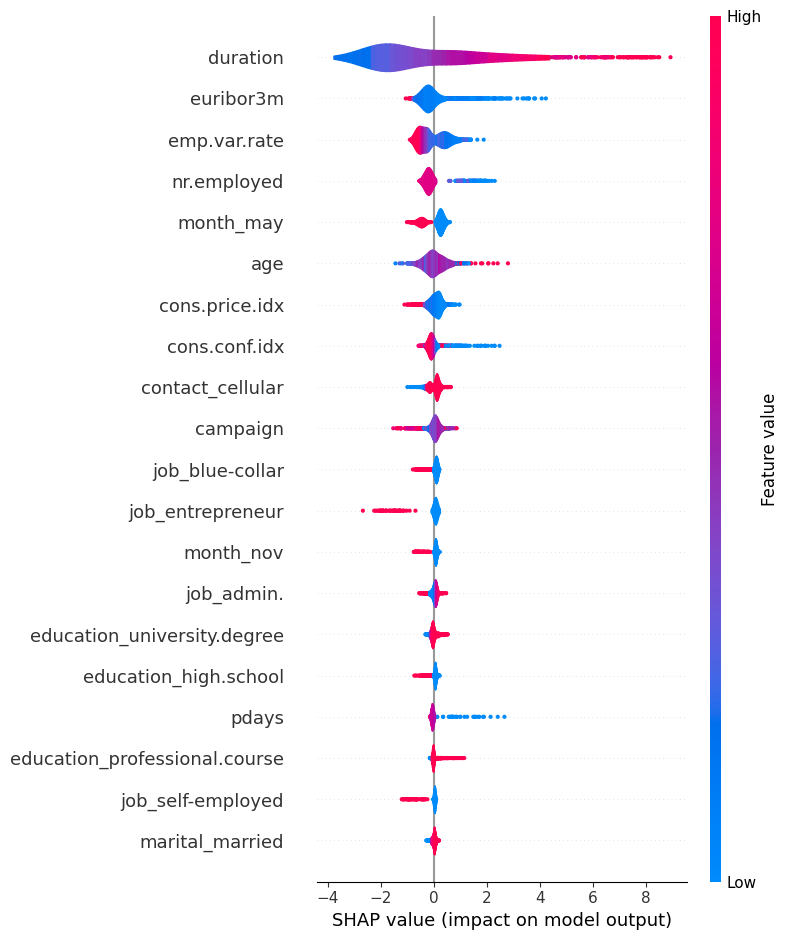

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="violin")

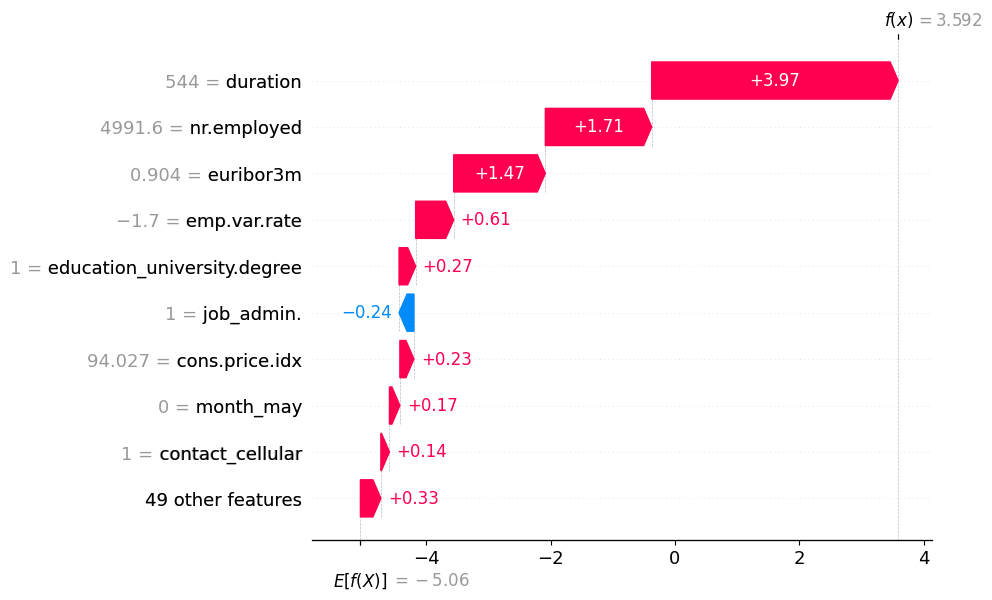

In [ ]:
shap.plots.waterfall(shap_values[0])


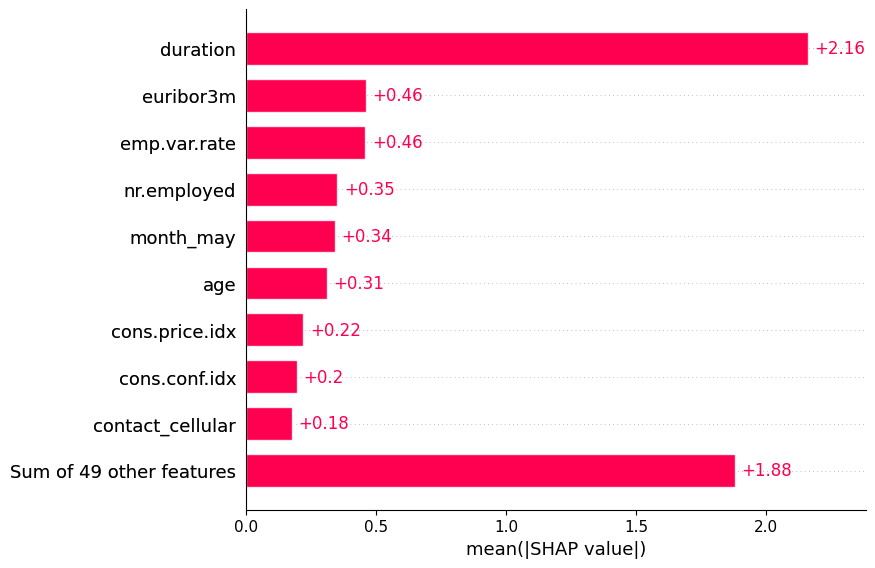

In [ ]:
shap.plots.bar(shap_values)